In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio
from rasterio.enums import Resampling
import matplotlib.colors as mcolors
import xarray as xr
import cftime
import math
import rioxarray
from shapely.geometry import mapping
import cartopy.crs as ccrs
import matplotlib as mpl

In [4]:
from pathlib import Path
import sys
import os

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[0]}/"
# print(path_mod)
sys.path.append(path_mod)
from src.indicators.drought.config import Config
from src.utils_general.utils import download_url

In [5]:
def plot_geo_var(df, sub_col, var_col, title=None, predef_bins=None, colp_num=2, cmap='YlOrRd',figsize=(16,9)):
    #plots one legend for all subplots. Version in eth notebook plots legend per subplot
    """
    Plot the values of "col" for the dates present in df_trig
    If giving predef_bins then the data will be colored according to the bins, else a different colour will be assigned to each unique value in the data for each date
    df: DataFrame containing all the data of all regions
    df_trig: DataFrame containing the dates for which plots should be shown (generally those dates that the trigger is met)
    col: string with column to plot
    shape_path: relative path to the admin1 shapefile
    title: string with title of whole figure (so not the subplots)
    predef_bins: list with bin values
    """

    num_plots = len(df[sub_col].unique())
    if num_plots==1:
        colp_num=1
    rows = math.ceil(num_plots / colp_num)

    position = range(1, num_plots + 1)
    fig, axs = plt.subplots(rows,colp_num,figsize=figsize, 
                        facecolor='w',
                        constrained_layout=True, 
                        sharex=True, sharey=True, 
                        subplot_kw=dict(aspect='equal'))

    axs = axs.ravel()

    if predef_bins is not None:
        scheme = None
        norm2 = mcolors.BoundaryNorm(boundaries=predef_bins, ncolors=256)
        legend_kwds=None
    else:
        scheme = "natural_breaks"
        norm2 = None
        legend_kwds = {'bbox_to_anchor': (1.6, 1)}

#     figsize = (16, 10)
#     fig = plt.figure(1, figsize=(16, 6 * rows))

    for i, c in enumerate(df[sub_col].unique()):
#         ax = fig.add_subplot(rows, colp_num, position[i])

        df_sub = df[df[sub_col] == c]
        #if no predef bins, set unique color for each unique value
        if predef_bins is None:
            colors = len(df_sub[var_col].dropna().unique())
        #else colors will be determined by norm and cmap
        else:
            colors = None

        if df_sub[var_col].isnull().values.all():
            print(f"No not-NaN values for {c}")
        elif df_sub[var_col].isnull().values.any():
            df_sub.plot(var_col, ax=axs[i], cmap=cmap, k=colors, norm=norm2, legend=False, scheme=scheme,
                        missing_kwds={"color": "lightgrey", "edgecolor": "red",
                                      "hatch": "///",
                                      "label": "Missing values"})
        else:
            df_sub.plot(var_col, ax=axs[i], cmap=cmap, k=colors, norm=norm2, legend=False, scheme=scheme)
        df.boundary.plot(linewidth=0.2, ax=axs[i])

        axs[i].axis("off")
        axs[i].set_title(c) #pd.DatetimeIndex([c])[0].to_period('M'))
        
#     fig.subplots_adjust(right=0.8)
#     cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#     fig.colorbar(ax, cax=cbar_ax)
#     fig.colorbar(ax, ax=axes.ravel().tolist())
    # assume it's the first (and only) mappable
    patch_col = axs[0].collections[0]
    cb = fig.colorbar(patch_col, ax=axs, shrink=0.5)

#         #prettify legend if using individual color for each value
#         if predef_bins is None and not df_sub[var_col].isnull().values.all():
#             leg = ax.get_legend()

#             for lbl in leg.get_texts():
#                 label_text = lbl.get_text()
#                 upper = label_text.split(",")[-1].rstrip(']')

#                 try:
#                     new_text = f'{float(upper):,.2f}'
#                 except:
#                     new_text = upper
#                 lbl.set_text(new_text)

        
    if title:
        fig.suptitle(title, fontsize=14, y=0.92)
#     fig.tight_layout()

    return fig

#### Set config values

In [6]:
country="malawi"
config=Config()
parameters = config.parameters(country)
country_folder = os.path.join(config.DIR_PATH, config.ANALYSES_DIR, country)

In [7]:
adm1_bound_path=os.path.join(country_folder,config.DATA_DIR,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
adm2_bound_path=os.path.join(country_folder,config.DATA_DIR,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])

In [8]:
def get_new_name(name, n_dict):
    """
    Return the values of a dict if name is in the keys of the dict
    Args:
        name: string of interest
        n_dict: dict with possibly "name" as key

    Returns:

    """
    if name in n_dict.keys():
        return n_dict[name]
    else:
        return name

In [9]:
#annual summary
asi_url_annual=f"http://www.fao.org/giews/earthobservation/asis/data/country/{parameters['iso3_code']}/MAP_ASI/DATA/ASI_AnnualSummary_Season1_data.csv"
##dekad summary
asi_url_dekad=f"http://www.fao.org/giews/earthobservation/asis/data/country/{parameters['iso3_code']}/MAP_ASI/DATA/ASI_Dekad_Season1_data.csv"

In [10]:
#only needed if not downloaded yet
download_url(asi_url_annual,f"Data/{country}_asi_annual.csv")
download_url(asi_url_dekad,f"Data/{country}_asi_dekad.csv")

In [12]:
df=pd.read_csv(f"Data/{country}_asi_annual.csv")
df.columns = map(str.lower, df.columns)

In [11]:
dfd=pd.read_csv(f"Data/{country}_asi_dekad.csv")
dfd.columns = map(str.lower, dfd.columns)
dfd["date"]=pd.to_datetime(dfd.date)

In [12]:
df

,crop_mask,country,adm1_code,province,year,data,unit
0,Cropland,Malawi,NaN,ALL,2019,5.238,VHI % below 35
1,Cropland,Malawi,NaN,ALL,2018,4.480,VHI % below 35
2,Cropland,Malawi,NaN,ALL,2017,1.301,VHI % below 35
3,Cropland,Malawi,NaN,ALL,2016,18.457,VHI % below 35
4,Cropland,Malawi,NaN,ALL,2015,6.350,VHI % below 35
...,...,...,...,...,...,...,...
175,Cropland,Malawi,65268.0,Area under National Administration,1985,0.000,VHI % below 35
176,Cropland,Malawi,1888.0,Central Region,1984,0.000,VHI % below 35
177,Cropland,Malawi,1889.0,Northern Region,1984,0.122,VHI % below 35
178,Cropland,Malawi,1890.0,Southern Region,1984,0.000,VHI % below 35


In [13]:
df[df.year==2019]

,crop_mask,country,adm1_code,province,year,data,unit
0,Cropland,Malawi,NaN,ALL,2019,5.238,VHI % below 35
36,Cropland,Malawi,1888.0,Central Region,2019,3.808,VHI % below 35
37,Cropland,Malawi,1889.0,Northern Region,2019,15.722,VHI % below 35
38,Cropland,Malawi,1890.0,Southern Region,2019,0.891,VHI % below 35
39,Cropland,Malawi,65268.0,Area under National Administration,2019,74.490,VHI % below 35


In [14]:
df[(df.year==2019)&(df.province!="ALL")].mean()

adm1_code    17733.75000
year          2019.00000
data            23.72775
dtype: float64

In [15]:
df[df.province=="ALL"].sort_values(by="data",ascending=False)

,crop_mask,country,adm1_code,province,year,data,unit
27,Cropland,Malawi,NaN,ALL,1992,61.226,VHI % below 35
3,Cropland,Malawi,NaN,ALL,2016,18.457,VHI % below 35
24,Cropland,Malawi,NaN,ALL,1995,10.324,VHI % below 35
15,Cropland,Malawi,NaN,ALL,2004,10.239,VHI % below 35
29,Cropland,Malawi,NaN,ALL,1990,9.350,VHI % below 35
4,Cropland,Malawi,NaN,ALL,2015,6.350,VHI % below 35
0,Cropland,Malawi,NaN,ALL,2019,5.238,VHI % below 35
16,Cropland,Malawi,NaN,ALL,2003,4.687,VHI % below 35
12,Cropland,Malawi,NaN,ALL,2007,4.624,VHI % below 35
13,Cropland,Malawi,NaN,ALL,2006,4.583,VHI % below 35


In [16]:
dfd[dfd.year==2019].groupby(["province","month"],as_index=False).mean()[["province","month","data"]]

,province,month,data
0,Area under National Administration,1,30.756000
1,Area under National Administration,2,12.957333
2,Area under National Administration,3,30.175000
3,Area under National Administration,4,55.485667
4,Area under National Administration,5,70.789000
5,Area under National Administration,6,78.823667
6,Area under National Administration,7,50.000000
7,Area under National Administration,11,60.256333
8,Area under National Administration,12,42.091667
9,Central Region,1,13.032000


In [17]:
dfd

,indicator,country,adm1_code,province,land_type,date,data,year,month,dekad,unit,source
0,Agricultural Stress Index (ASI),Malawi,65268,Area under National Administration,Crop Area,1984-01-01,8.333,1984,1,1,% of area with Mean VHI below 35,FAO
1,Agricultural Stress Index (ASI),Malawi,65268,Area under National Administration,Crop Area,1984-01-11,0.000,1984,1,2,% of area with Mean VHI below 35,FAO
2,Agricultural Stress Index (ASI),Malawi,65268,Area under National Administration,Crop Area,1984-01-21,0.000,1984,1,3,% of area with Mean VHI below 35,FAO
3,Agricultural Stress Index (ASI),Malawi,65268,Area under National Administration,Crop Area,1984-02-01,0.000,1984,2,1,% of area with Mean VHI below 35,FAO
4,Agricultural Stress Index (ASI),Malawi,65268,Area under National Administration,Crop Area,1984-02-11,0.000,1984,2,2,% of area with Mean VHI below 35,FAO
...,...,...,...,...,...,...,...,...,...,...,...,...
4443,Agricultural Stress Index (ASI),Malawi,1890,Southern Region,Crop Area,2020-12-11,6.223,2020,12,2,% of area with Mean VHI below 35,FAO
4444,Agricultural Stress Index (ASI),Malawi,1890,Southern Region,Crop Area,2020-12-21,4.461,2020,12,3,% of area with Mean VHI below 35,FAO
4445,Agricultural Stress Index (ASI),Malawi,1890,Southern Region,Crop Area,2021-01-01,4.810,2021,1,1,% of area with Mean VHI below 35,FAO
4446,Agricultural Stress Index (ASI),Malawi,1890,Southern Region,Crop Area,2021-01-11,3.692,2021,1,2,% of area with Mean VHI below 35,FAO


In [18]:
dfd[(dfd.year==2019)&(dfd.dekad==3)] #.groupby(["province"],as_index=False).mean()[["province","data"]]

,indicator,country,adm1_code,province,land_type,date,data,year,month,dekad,unit,source
875,Agricultural Stress Index (ASI),Malawi,65268,Area under National Administration,Crop Area,2019-01-21,20.690,2019,1,3,% of area with Mean VHI below 35,FAO
878,Agricultural Stress Index (ASI),Malawi,65268,Area under National Administration,Crop Area,2019-02-21,14.085,2019,2,3,% of area with Mean VHI below 35,FAO
881,Agricultural Stress Index (ASI),Malawi,65268,Area under National Administration,Crop Area,2019-03-21,34.328,2019,3,3,% of area with Mean VHI below 35,FAO
884,Agricultural Stress Index (ASI),Malawi,65268,Area under National Administration,Crop Area,2019-04-21,64.063,2019,4,3,% of area with Mean VHI below 35,FAO
887,Agricultural Stress Index (ASI),Malawi,65268,Area under National Administration,Crop Area,2019-05-21,78.333,2019,5,3,% of area with Mean VHI below 35,FAO
890,Agricultural Stress Index (ASI),Malawi,65268,Area under National Administration,Crop Area,2019-06-21,80.000,2019,6,3,% of area with Mean VHI below 35,FAO
894,Agricultural Stress Index (ASI),Malawi,65268,Area under National Administration,Crop Area,2019-11-21,30.769,2019,11,3,% of area with Mean VHI below 35,FAO
897,Agricultural Stress Index (ASI),Malawi,65268,Area under National Administration,Crop Area,2019-12-21,47.458,2019,12,3,% of area with Mean VHI below 35,FAO
1908,Agricultural Stress Index (ASI),Malawi,1888,Central Region,Crop Area,2019-01-21,7.419,2019,1,3,% of area with Mean VHI below 35,FAO
1911,Agricultural Stress Index (ASI),Malawi,1888,Central Region,Crop Area,2019-02-21,3.226,2019,2,3,% of area with Mean VHI below 35,FAO


In [13]:
# dfd

In [25]:
dfd.province.unique()

array(['Area under National Administration', 'Central Region',
       'Northern Region', 'Southern Region'], dtype=object)

In [20]:
df_bound = gpd.read_file(adm1_bound_path)

In [26]:
df_bound.ADM1_EN.unique()

array(['Central', 'Northern', 'Southern'], dtype=object)

In [27]:
province_mapping={"Central Region":"Central","Northern Region":"Northern","Southern Region":"Southern"}

In [28]:
dfd["province"]=dfd["province"].apply(
            lambda x: get_new_name(x, province_mapping))

In [29]:
dfdg=df_bound[["ADM1_EN","geometry"]].merge(dfd,left_on="ADM1_EN",right_on="province")

In [22]:
dfd

,indicator,country,adm1_code,province,land_type,date,data,year,month,dekad,unit,source
0,Agricultural Stress Index (ASI),Malawi,65268,Area under National Administration,Crop Area,1984-01-01,8.333,1984,1,1,% of area with Mean VHI below 35,FAO
1,Agricultural Stress Index (ASI),Malawi,65268,Area under National Administration,Crop Area,1984-01-11,0.000,1984,1,2,% of area with Mean VHI below 35,FAO
2,Agricultural Stress Index (ASI),Malawi,65268,Area under National Administration,Crop Area,1984-01-21,0.000,1984,1,3,% of area with Mean VHI below 35,FAO
3,Agricultural Stress Index (ASI),Malawi,65268,Area under National Administration,Crop Area,1984-02-01,0.000,1984,2,1,% of area with Mean VHI below 35,FAO
4,Agricultural Stress Index (ASI),Malawi,65268,Area under National Administration,Crop Area,1984-02-11,0.000,1984,2,2,% of area with Mean VHI below 35,FAO
...,...,...,...,...,...,...,...,...,...,...,...,...
4443,Agricultural Stress Index (ASI),Malawi,1890,Southern Region,Crop Area,2020-12-11,6.223,2020,12,2,% of area with Mean VHI below 35,FAO
4444,Agricultural Stress Index (ASI),Malawi,1890,Southern Region,Crop Area,2020-12-21,4.461,2020,12,3,% of area with Mean VHI below 35,FAO
4445,Agricultural Stress Index (ASI),Malawi,1890,Southern Region,Crop Area,2021-01-01,4.810,2021,1,1,% of area with Mean VHI below 35,FAO
4446,Agricultural Stress Index (ASI),Malawi,1890,Southern Region,Crop Area,2021-01-11,3.692,2021,1,2,% of area with Mean VHI below 35,FAO


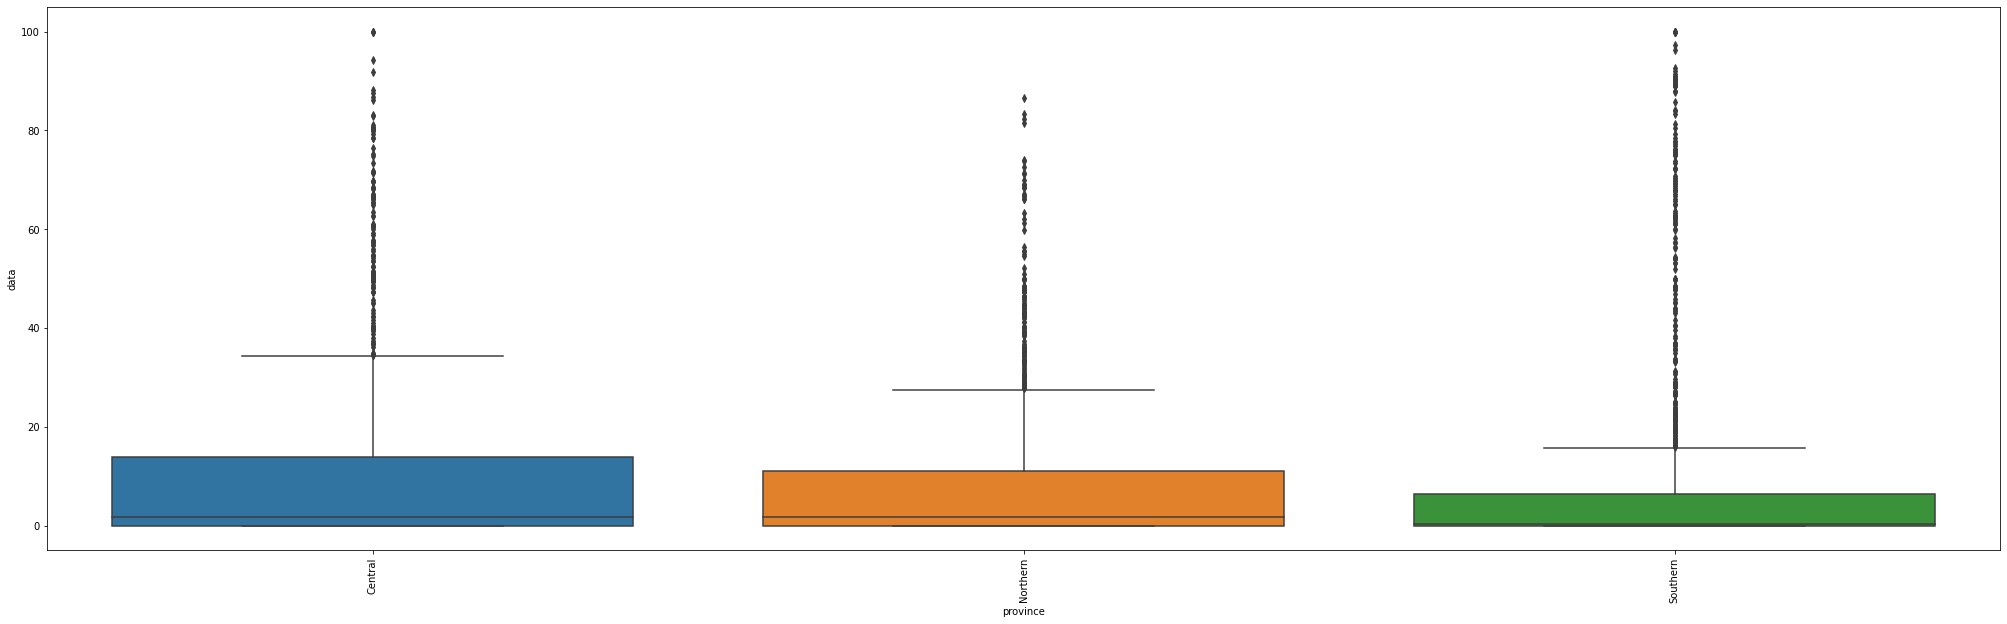

In [31]:
import seaborn as sns

# unit_officer=disciplines.groupby(['district_num','officer_id']).complaint_id.count().reset_index()

fig, ax = plt.subplots(1, 1,figsize=(35,10))
g=sns.boxplot(x="province", y="data",data=dfdg, ax=ax)
plt.xticks(rotation=90);
# ax.tick_params(labelsize=24);
# fig.suptitle('District Complaints/ Officer', fontsize=32);
# ax.set_xlabel('District Number', fontsize=24);
# ax.set_ylabel('Number of Complaints', fontsize=24);

In [32]:
dfd[(dfd.year==2019)&(dfd.dekad==3)&(dfd.province=="Somali")]

,indicator,country,adm1_code,province,land_type,date,data,year,month,dekad,unit,source


In [33]:
# fig=plot_geo_var(dfdg[(dfdg.year.isin(range(2019,2020)))&(dfdg.dekad==3)].sort_values("date"),"date","data",predef_bins=np.arange(0,100,10),colp_num=4)

In [34]:
df["province"]=df["province"].apply(
            lambda x: get_new_name(x, province_mapping))

In [35]:
dfg=df_bound[["ADM1_EN","geometry"]].merge(df,left_on="ADM1_EN",right_on="province")

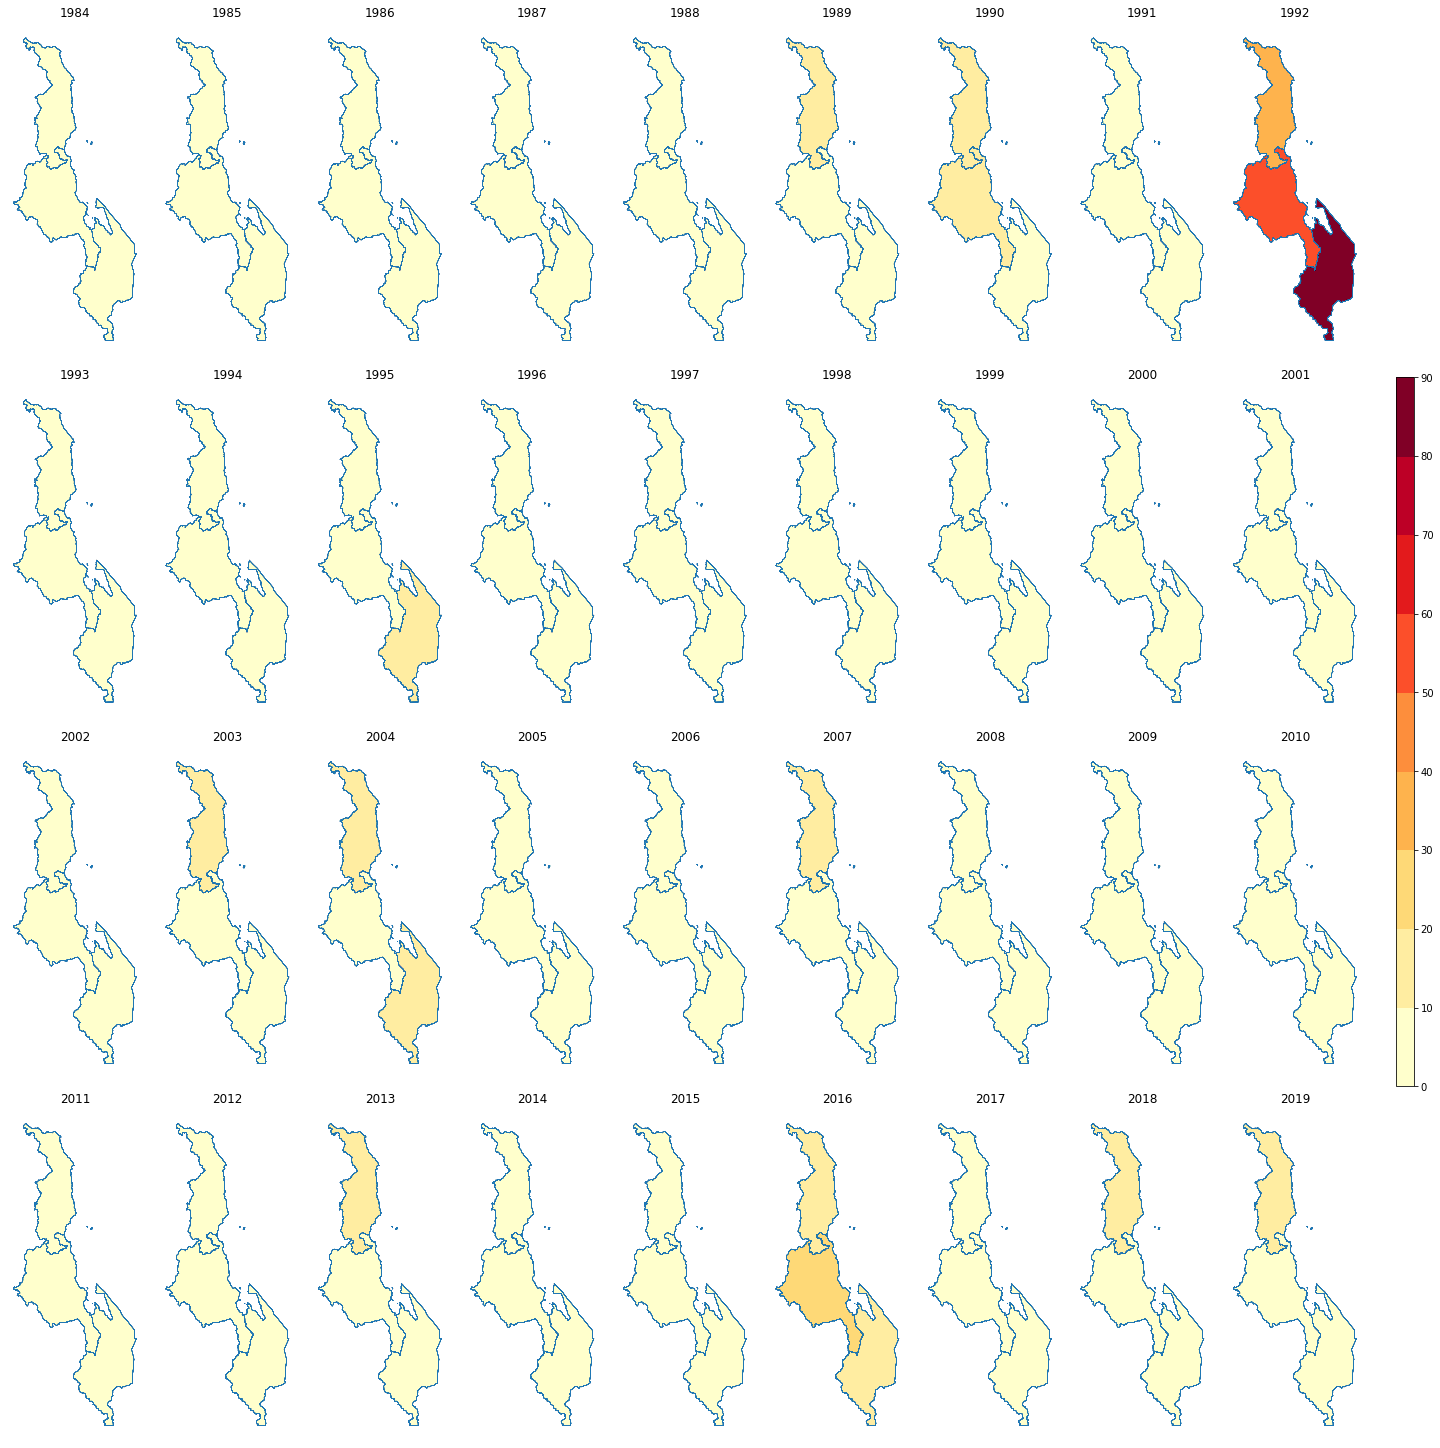

In [45]:
fig=plot_geo_var(dfg.sort_values("year"),"year","data",predef_bins=np.arange(0,100,10),colp_num=9,figsize=(20,20))

In [46]:
# fig.savefig('Data/mwi_ASI_annual.png', bbox_inches='tight')